## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-09-09 10:25:30.024318: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 10:25:31.995693: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-09 10:25:34.532133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib 

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 8.8%
RAM Usage: 5.6%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


In [6]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0
GPU found 0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [7]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

### Attention pooling analysis

In [8]:
from models.base_models import ModelBuild, BaseModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel
from models.transformer_models import SharedSelfAttentionPoolingModel, SharedSelfAttentionCLSPoolingModel
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset

### Load UKBB data and loaders

In [9]:
# Load data
print("Loading data...")
X_UKBB = load_transcriptome(parcellation='S456', hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate')
Y_UKBB = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords_UKBB = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels_UKBB, network_labels_UKBB = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices_UKBB = ~np.isnan(X_UKBB).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values_UKBB = np.where(valid_indices_UKBB)[0]
valid2true_mapping_UKBB = dict(enumerate(valid_indices_values_UKBB))

# Subset all data using valid indices
X_UKBB_valid = X_UKBB[valid_indices_UKBB]
Y_UKBB_valid = Y_UKBB[valid_indices_UKBB][:, valid_indices_UKBB]
coords_UKBB_valid = coords_UKBB[valid_indices_UKBB]
labels_UKBB = [labels_UKBB[i] for i in range(len(labels_UKBB)) if valid_indices_UKBB[i]]
network_labels_UKBB = network_labels_UKBB[valid_indices_UKBB]

print(f"X_UKBB_valid shape: {X_UKBB_valid.shape}")

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset_UKBB = RegionPairDataset(
    X=X_UKBB_valid,
    Y=Y_UKBB_valid,
    coords=coords_UKBB_valid,
    valid2true_mapping=valid2true_mapping_UKBB,
    dataset='UKBB',
    parcellation='S456'
)

batch_size = 1024

# Create dataloader with all pairs
dataloader_UKBB = DataLoader(
    dataset_UKBB,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)


Loading data...
X_UKBB_valid shape: (455, 7380)
Creating RegionPairDataset...


In [12]:
# Initialized the model using saved weights
smt_UKBB_model = SharedSelfAttentionPoolingModel(input_dim=14760, token_encoder_dim=20, d_model=128,
                                                   nhead=4, num_layers=4,
                                                   deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.1,
                                                   dropout_rate=0.1, learning_rate=0.0007, weight_decay=0.00001,
                                                   batch_size=1024, aug_prob=0.0, epochs=110, num_workers=2, prefetch_factor=4)

smt_UKBB_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_pool_seed42_0_v2.pt"))
smt_UKBB_model.eval()
smt_UKBB_model.to("cuda")

  warnings.warn(



Number of learnable parameters in SMT model: 1064706


SharedSelfAttentionPoolingModel(
  (criterion): MSELoss()
  (encoder): OptimizedModule(
    (_orig_mod): FlashAttentionEncoder(
      (input_projection): Linear(in_features=20, out_features=128, bias=True)
      (transformer_layers): ModuleList(
        (0-3): 4 x FlashAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.1, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (pooling): AttentionPooling(
        (theta1): Linear(in_features=128, out_features=32, bias=True)
        (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, 

Embeddings shape: torch.Size([455, 128])
Attention weights shape: torch.Size([455, 369])


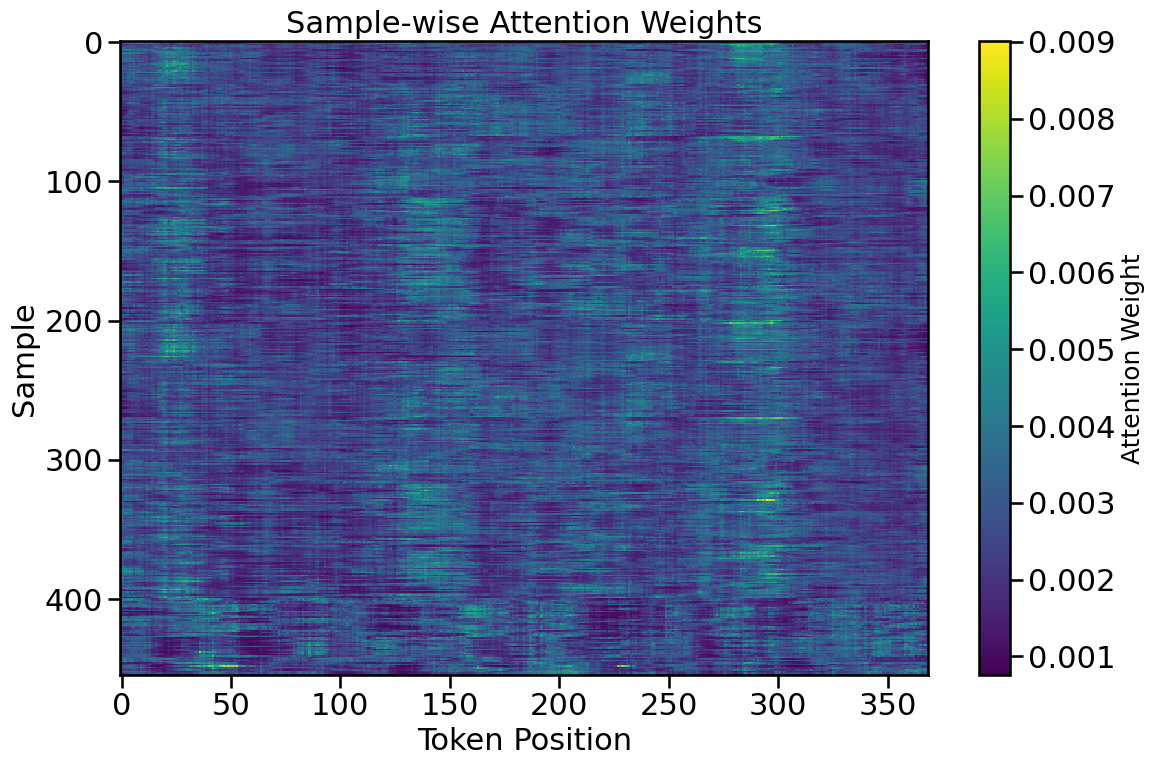

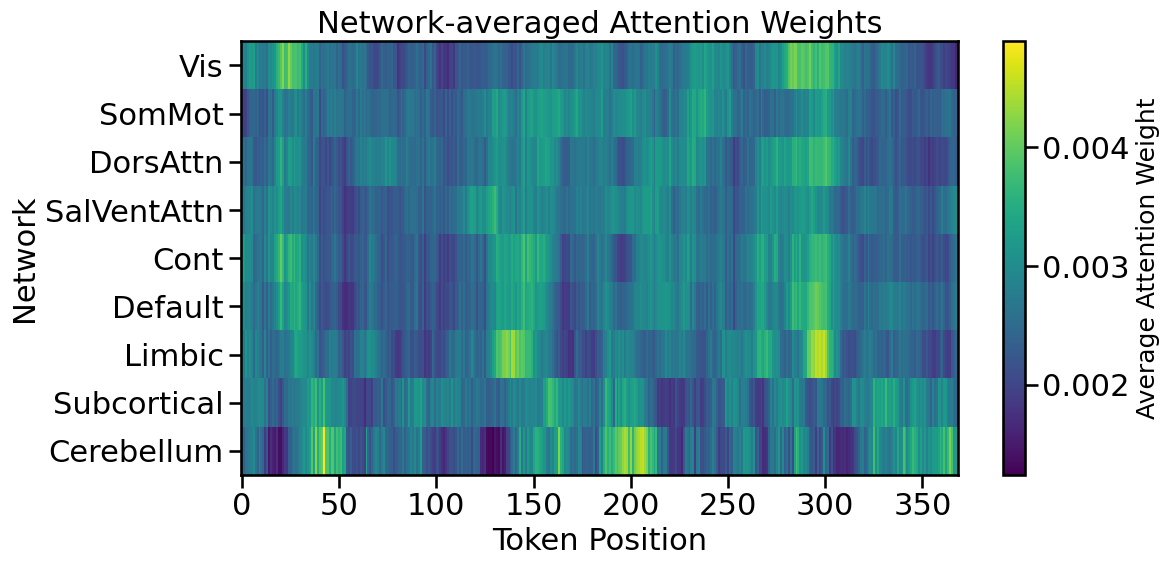

In [13]:
# Isolate the encoder
smt_UKBB_model.encoder.eval()
smt_UKBB_model.encoder.to("cuda")

# Create dataset from X_UKBB_valid that contains each ROI as a sample
X = torch.tensor(X_UKBB_valid, dtype=torch.float32).to("cuda")
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=X_UKBB_valid.shape[0], shuffle=False)

# Get embeddings and attention weights from encoder
embeddings = []
attention_weights = []

with torch.no_grad():
    for batch in dataloader:
        # Pass through encoder and get embeddings and attention weights
        emb, attn = smt_UKBB_model.encoder(batch[0], return_attn=True)
        
        embeddings.append(emb)
        attention_weights.append(attn)

embeddings = torch.cat(embeddings, dim=0)
attention_weights = torch.cat(attention_weights, dim=0)
print("Embeddings shape:", embeddings.shape)
print("Attention weights shape:", attention_weights.shape)

# Set global font size for plots
FONTSIZE = 22

# Move attention weights to CPU and convert to numpy
attention_weights = attention_weights.cpu().numpy()

# First visualize raw attention weights for each sample
plt.figure(figsize=(12, 8))
plt.imshow(attention_weights, aspect='auto', cmap='viridis', interpolation='none')
cbar = plt.colorbar(label='Attention Weight')
cbar.ax.tick_params(labelsize=FONTSIZE)
plt.title('Sample-wise Attention Weights', fontsize=FONTSIZE)
plt.xlabel('Token Position', fontsize=FONTSIZE)
plt.ylabel('Sample', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

# Network info defining functional subnetworks and their sizes
network_info = {
    0: ('Vis', 3660),
    1: ('SomMot', 5852), 
    2: ('DorsAttn', 2070),
    3: ('SalVentAttn', 2162),
    4: ('Cont', 2652),
    5: ('Default', 8190),
    6: ('Limbic', 650),
    7: ('Subcortical', 2070),
    8: ('Cerebellum', 72)
}

# Get network labels and initialize array for averaged attention
network_labels = [info[0] for info in network_info.values()]
avg_attention = np.zeros((len(network_info), attention_weights.shape[1]))

# Average attention weights by network
for i, (_, (network_name, _)) in enumerate(network_info.items()):
    network_mask = network_labels_UKBB == network_name
    avg_attention[i] = np.mean(attention_weights[network_mask], axis=0)

# Plot network-averaged attention
plt.figure(figsize=(12, 6))
plt.imshow(avg_attention, aspect='auto', cmap='viridis', interpolation='none')
cbar = plt.colorbar(label='Average Attention Weight')
cbar.ax.tick_params(labelsize=FONTSIZE)
plt.title('Network-averaged Attention Weights', fontsize=FONTSIZE)
plt.xlabel('Token Position', fontsize=FONTSIZE)
plt.ylabel('Network', fontsize=FONTSIZE)
plt.yticks(range(len(network_labels)), network_labels, fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

SMT w/ CLS

In [26]:
smt_cls_UKBB_model = SharedSelfAttentionCLSPoolingModel(input_dim=14760, token_encoder_dim=20, d_model=128,
                                                   nhead=4, num_layers=4,
                                                   deep_hidden_dims=[512, 256, 128], use_alibi=True, transformer_dropout=0.1,
                                                   dropout_rate=0.1, learning_rate=0.0007, weight_decay=0.00001,
                                                   batch_size=1024, aug_prob=0.0, epochs=110, cls_init='spatial_learned',
                                                   cls_dropout=0.5)

smt_cls_UKBB_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_smt_cls_pool_seed42_0_v4.pt"))
smt_cls_UKBB_model.eval()
smt_cls_UKBB_model.to("cuda")

  warnings.warn(



Number of learnable parameters in SMT w/ CLS pooled model: 1081858


SharedSelfAttentionCLSPoolingModel(
  (criterion): MSELoss()
  (encoder): OptimizedModule(
    (_orig_mod): SelfAttentionCLSEncoder(
      (input_projection): Linear(in_features=20, out_features=128, bias=True)
      (coord_encoder): Sequential(
        (0): Linear(in_features=4, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (cls_dropout): Dropout(p=0.5, inplace=False)
      (transformer_layers): ModuleList(
        (0-3): 4 x FlashAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.1, inplace=False)

Embeddings shape: torch.Size([455, 128])
Attention weights shape: torch.Size([455, 369])


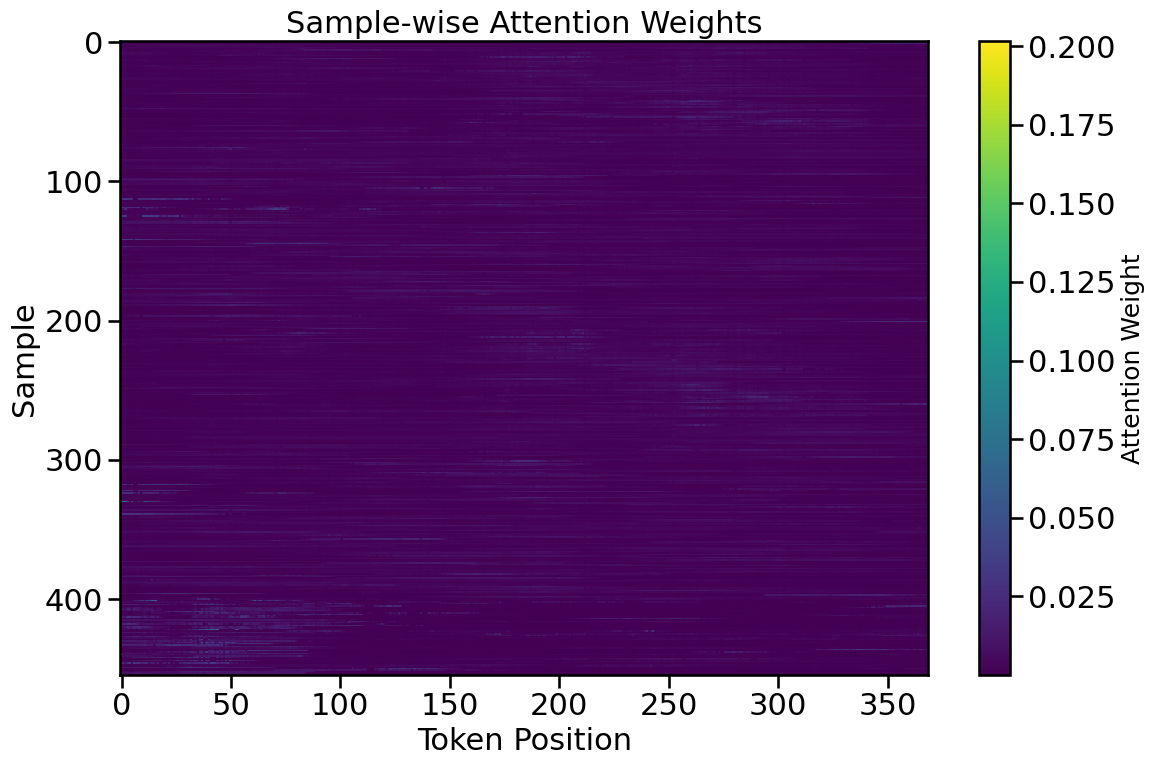

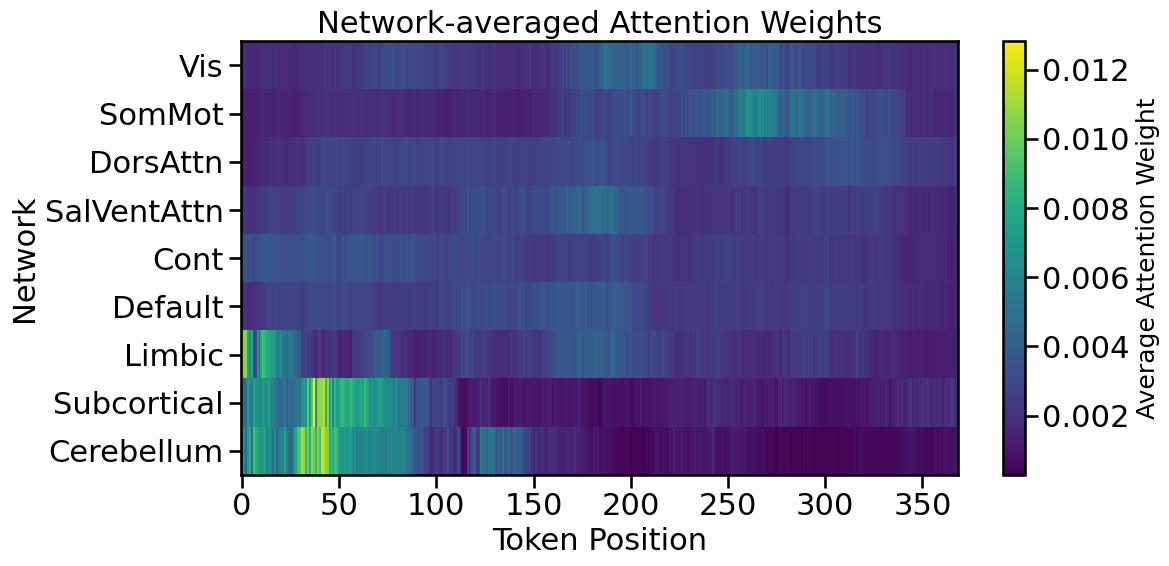

In [27]:
# Isolate the encoder
smt_cls_UKBB_model.encoder.eval()
smt_cls_UKBB_model.encoder.to("cuda")

# Create dataset from X_UKBB_valid that contains each ROI as a sample
X = torch.tensor(X_UKBB_valid, dtype=torch.float32).to("cuda")
coords = torch.tensor(coords_UKBB_valid, dtype=torch.float32).to("cuda")
dist_to_target = torch.zeros_like(coords[:, :1]).to("cuda") # Initialize dist_to_target as zeros
dataset = TensorDataset(X, coords, dist_to_target)
dataloader = DataLoader(dataset, batch_size=X_UKBB_valid.shape[0], shuffle=False)

# Get embeddings and attention weights from encoder
embeddings = []
attention_weights = []

with torch.no_grad():
    for batch in dataloader:
        # Pass through encoder and get embeddings and attention weights
        emb, attn = smt_cls_UKBB_model.encoder(batch[0], batch[1], batch[2], return_attn=True)
        
        embeddings.append(emb)
        attention_weights.append(attn)

embeddings = torch.cat(embeddings, dim=0)
attention_weights = torch.cat(attention_weights, dim=0)
print("Embeddings shape:", embeddings.shape)
print("Attention weights shape:", attention_weights.shape)

# Set global font size for plots
FONTSIZE = 22

# Move attention weights to CPU and convert to numpy
attention_weights = attention_weights.cpu().numpy()

# First visualize raw attention weights for each sample
plt.figure(figsize=(12, 8))
plt.imshow(attention_weights, aspect='auto', cmap='viridis', interpolation='none')
cbar = plt.colorbar(label='Attention Weight')
cbar.ax.tick_params(labelsize=FONTSIZE)
plt.title('Sample-wise Attention Weights', fontsize=FONTSIZE)
plt.xlabel('Token Position', fontsize=FONTSIZE)
plt.ylabel('Sample', fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

# Network info defining functional subnetworks and their sizes
network_info = {
    0: ('Vis', 3660),
    1: ('SomMot', 5852), 
    2: ('DorsAttn', 2070),
    3: ('SalVentAttn', 2162),
    4: ('Cont', 2652),
    5: ('Default', 8190),
    6: ('Limbic', 650),
    7: ('Subcortical', 2070),
    8: ('Cerebellum', 72)
}

# Get network labels and initialize array for averaged attention
network_labels = [info[0] for info in network_info.values()]
avg_attention = np.zeros((len(network_info), attention_weights.shape[1]))

# Average attention weights by network
for i, (_, (network_name, _)) in enumerate(network_info.items()):
    network_mask = network_labels_UKBB == network_name
    avg_attention[i] = np.mean(attention_weights[network_mask], axis=0)

# Plot network-averaged attention
plt.figure(figsize=(12, 6))
plt.imshow(avg_attention, aspect='auto', cmap='viridis', interpolation='none')
cbar = plt.colorbar(label='Average Attention Weight')
cbar.ax.tick_params(labelsize=FONTSIZE)
plt.title('Network-averaged Attention Weights', fontsize=FONTSIZE)
plt.xlabel('Token Position', fontsize=FONTSIZE)
plt.ylabel('Network', fontsize=FONTSIZE)
plt.yticks(range(len(network_labels)), network_labels, fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

Map gene tokens to corresponding genes

In [40]:
def create_gene_tokens(token_chunk_size=20):
    """
    Create gene tokens and chromosome switch points based on token chunk size
    
    Args:
        token_chunk_size (int): Number of genes per token
        
    Returns:
        gene_tokens (list): List of dictionaries containing token info
        chrom_switches (list): List of indices where chromosomes switch
    """
    # Get valid genes from load_transcriptome
    from data.data_load import load_transcriptome

    X, valid_genes = load_transcriptome(parcellation='S456', gene_list='0.2', dataset='AHBA', 
                                      run_PCA=False, omit_subcortical=False, hemisphere='both',
                                      impute_strategy='mirror_interpolate', sort_genes='refgenome', 
                                      return_valid_genes=True, null_model='none', random_seed=42)

    # Get reference genome info for valid genes
    refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')

    valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)].drop_duplicates(subset='gene_id', keep='first')
    
    # Create gene groups/tokens
    num_tokens = len(valid_refgenome) // token_chunk_size
    
    gene_tokens = []

    for i in range(num_tokens):
        start_idx = i * token_chunk_size
        end_idx = start_idx + token_chunk_size
        token_genes = valid_refgenome.iloc[start_idx:end_idx]
        
        # Get unique chromosome for this token
        chrom = token_genes['chromosome'].iloc[0]
        
        token = {
            'token_id': i,
            'genes': token_genes['gene_id'].tolist(),
            'chromosome': chrom
        }
        gene_tokens.append(token)

    # Handle remaining genes if any
    remaining_genes = len(valid_refgenome) % token_chunk_size
    if remaining_genes > 0:
        start_idx = num_tokens * token_chunk_size
        token_genes = valid_refgenome.iloc[start_idx:]
        token = {
            'token_id': num_tokens,
            'genes': token_genes['gene_id'].tolist(), 
            'chromosome': token_genes['chromosome'].iloc[0]
        }
        gene_tokens.append(token)
    # Get chromosome switch points
    chrom_switches = []
    for i in range(1, len(gene_tokens)):
        if gene_tokens[i]['chromosome'] != gene_tokens[i-1]['chromosome']:
            chrom_switches.append(i)
    
    # Print token and switch point info
    print(f"Number of tokens: {len(gene_tokens)}")
    print(f"Number of chromosome switch points: {len(chrom_switches)}")
    print("Example token:")
    print(gene_tokens[0])
    # Print chromosome switches to validate
    print("Chromosome switch points:")
    for i in chrom_switches:
        print(f"Switch at token {i}: {gene_tokens[i-1]['chromosome']} -> {gene_tokens[i]['chromosome']}")
    print('\n')
    return gene_tokens, chrom_switches

gene_tokens_20, chrom_switches_20 = create_gene_tokens(token_chunk_size=20)
gene_tokens_60, chrom_switches_60 = create_gene_tokens(token_chunk_size=60)

Number of tokens: 369
Number of chromosome switch points: 22
Example token:
{'token_id': 0, 'genes': ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10'], 'chromosome': 'NC_000001.11'}
Chromosome switch points:
Switch at token 37: NC_000001.11 -> NC_000002.12
Switch at token 62: NC_000002.12 -> NC_000003.12
Switch at token 84: NC_000003.12 -> NC_000004.12
Switch at token 99: NC_000004.12 -> NC_000005.10
Switch at token 118: NC_000005.10 -> NC_000006.12
Switch at token 137: NC_000006.12 -> NC_000007.14
Switch at token 154: NC_000007.14 -> NC_000008.11
Switch at token 168: NC_000008.11 -> NC_000009.12
Switch at token 182: NC_000009.12 -> NC_000010.11
Switch at token 198: NC_000010.11 -> NC_000011.10
Switch at token 219: NC_000011.10 -> NC_000012.12
Switch at token 239: NC_000012.12 -> NC_000013.11
Switch at token 246: NC_000013.11 -> NC_000014.9
Swi

In [ ]:
# Create datasets for each subnetwork
# labels_UKBB, network_labels_UKBB = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

unique_networks = np.unique(network_labels_UKBB)
network_datasets = {}
print("Creating datasets for each subnetwork...")

for network in unique_networks:
    # Create mask for current network
    network_mask = network_labels_UKBB == network
    
    # Subset data for this network
    X_network = X_UKBB_valid[network_mask]
    Y_network = Y_UKBB_valid[network_mask][:, network_mask]
    coords_network = coords_UKBB_valid[network_mask]
    
    # Create mapping from network indices to true indices
    network_indices = np.where(network_mask)[0]
    network2true_mapping = {i: valid2true_mapping_UKBB[idx] for i, idx in enumerate(network_indices)}
    
    # Create dataset for this network
    network_datasets[network] = RegionPairDataset(
        X=X_network,
        Y=Y_network, 
        coords=coords_network,
        valid2true_mapping=network2true_mapping, 
        dataset='UKBB', 
        parcellation='S456'
    )
    print(f"Network {network}: {len(network_datasets[network])} region pairs")

# Create dataloaders for each network
batch_size = 512
network_dataloaders = {
    network: DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    ) for network, dataset in network_datasets.items()
}

network_dataloaders

# Collect attention for each subnetwork
network_info = {
    0: ('Cerebellum', 72),
    1: ('Cont', 2652), 
    2: ('Default', 8190),
    3: ('DorsAttn', 2070),
    4: ('Limbic', 650),
    5: ('SalVentAttn', 2162),
    6: ('SomMot', 5852),
    7: ('Subcortical', 2070),
    8: ('Vis', 3660)
}

In [ ]:
# reorder network info to match desired plotting order
network_info = {
    'Vis': ('Vis', 3660),
    'SomMot': ('SomMot', 5852), 
    'DorsAttn': ('DorsAttn', 2070),
    'SalVentAttn': ('SalVentAttn', 2162),
    'Cont': ('Cont', 2652),
    'Default': ('Default', 8190),
    'Limbic': ('Limbic', 650),
    'Subcortical': ('Subcortical', 2070),
    'Cerebellum': ('Cerebellum', 72)
}

# Collect attention for each subnetwork
network_attns = {}
for network, dataloader in network_dataloaders.items():
    # Get predictions and attention weights for this network
    _, _, network_attn, all_attn = smt_UKBB_model.predict(dataloader, collect_attn=True)
    network_attns[network] = network_attn.squeeze()  # Remove extra dimensions


In [82]:
# Get attention weights for base model with pooling
predictions_ukbb_base, targets_ukbb_base, avg_pooled_attn, all_attn = smt_UKBB_model.predict(dataloader_UKBB, collect_attn=True, save_attn_path=None) #'attn_SMT_pooling_ukbb_seed42_0.npy')
print("Predictions shape:", predictions_ukbb_base.shape)
print("Targets shape:", targets_ukbb_base.shape) 
print("Average pooled attention shape:", avg_pooled_attn.shape)

Predictions shape: (206570,)
Targets shape: (206570,)
Average pooled attention shape: (123,)


In [83]:
# Convert attention tensors to numpy arrays
attn_arrays = []
for attn_i, attn_j in all_attn:
    #attn_arrays.append(attn_i.cpu().numpy())
    attn_arrays.append(attn_j.cpu().numpy())


In [85]:
# Stack all attention arrays into one large array
all_attn = np.vstack(attn_arrays)
all_attn

array([[0.00719036, 0.00787616, 0.00618326, ..., 0.00999271, 0.00979569,
        0.01064832],
       [0.00594785, 0.00464509, 0.00566279, ..., 0.00902739, 0.00899248,
        0.00871648],
       [0.0090868 , 0.00727937, 0.00776686, ..., 0.01028566, 0.01033786,
        0.01081677],
       ...,
       [0.00407721, 0.00493822, 0.00506954, ..., 0.00759672, 0.00768037,
        0.01061489],
       [0.00255971, 0.00264765, 0.00290418, ..., 0.00721421, 0.01030067,
        0.01388345],
       [0.00429742, 0.00523638, 0.00485837, ..., 0.00919979, 0.00776521,
        0.01099595]], dtype=float32)

In [86]:
all_attn.shape

(206570, 123)

In [89]:
# Check number of unique rows with small tolerance
unique_rows = np.unique(all_attn.round(decimals=4), axis=0)
print(f"Total rows: {all_attn.shape[0]}")
print(f"Unique rows: {unique_rows.shape[0]}")

Total rows: 206570
Unique rows: 472


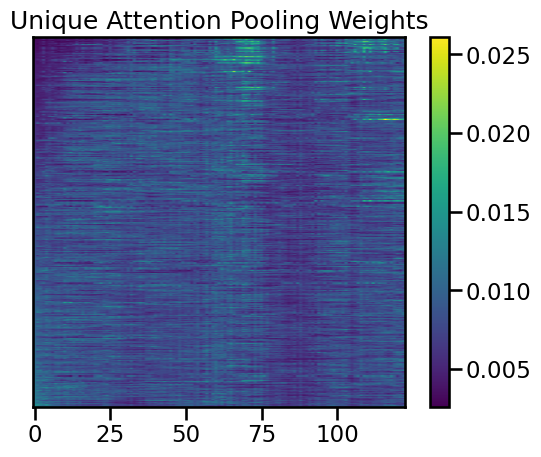

In [90]:
plt.imshow(unique_rows, cmap='viridis', aspect='auto')
plt.colorbar(fraction=0.2)
plt.yticks([])
plt.title('Unique Attention Pooling Weights')
plt.show()

[0.00798963 0.00777432 0.00759365 0.00758421 0.00798499 0.00792313
 0.00746648 0.00771693 0.00791914 0.00760013 0.00813923 0.00833158
 0.00808906 0.00844522 0.00825603 0.00826198 0.00826497 0.00806481
 0.00789112 0.00802676 0.00850902 0.00848098 0.00821553 0.00834211
 0.00858244 0.00848068 0.00858251 0.00826138 0.00858451 0.00797437
 0.00794372 0.00793026 0.00829878 0.00798169 0.00794001 0.00847837
 0.00807924 0.00823515 0.0082782  0.00835047 0.00861843 0.00809235
 0.00836079 0.008304   0.00800021 0.00872169 0.0084726  0.0081904
 0.00885586 0.0082834  0.00848889 0.00859316 0.00812183 0.0083075
 0.0085001  0.0076144  0.00832396 0.00898559 0.00814213 0.00887719
 0.00944383 0.00895581 0.00930101 0.00860646 0.00921228 0.00964053
 0.00861797 0.00899347 0.00869972 0.00955385 0.00955965 0.00902731
 0.00834634 0.0092114  0.0084508  0.00880281 0.00763454 0.00759154
 0.00697697 0.00744605 0.00728447 0.0073541  0.00720693 0.00694105
 0.00643208 0.00670278 0.00685004 0.00642941 0.00727998 0.006506

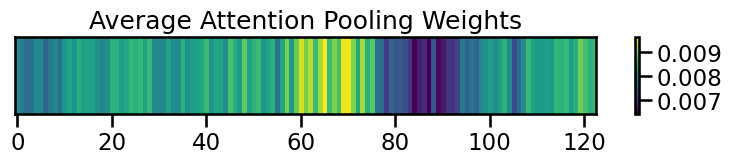

In [49]:
# Load and display attention weights
# attn_weights = np.load('notebooks/NeurIPS/attn_heads/attn_base_SMT_pooling_ukbb_seed42_fold0.npy')
attn_weights = avg_pooled_attn
print(attn_weights)
plt.figure(figsize=(10,1))
plt.imshow(attn_weights.reshape(1,-1), cmap='viridis', aspect='auto')
plt.colorbar(fraction=0.2)
plt.yticks([])
plt.title('Average Attention Pooling Weights')
plt.show()

In [43]:
# reorder network info to match desired plotting order
network_info = {
    'Vis': ('Vis', 3660),
    'SomMot': ('SomMot', 5852), 
    'DorsAttn': ('DorsAttn', 2070),
    'SalVentAttn': ('SalVentAttn', 2162),
    'Cont': ('Cont', 2652),
    'Default': ('Default', 8190),
    'Limbic': ('Limbic', 650),
    'Subcortical': ('Subcortical', 2070),
    'Cerebellum': ('Cerebellum', 72)
}

# Collect attention for each subnetwork
network_attns = {}
for network, dataloader in network_dataloaders.items():
    # Get predictions and attention weights for this network
    _, _, network_attn = smt_UKBB_model.predict(dataloader, collect_attn=True)
    network_attns[network] = network_attn.squeeze()  # Remove extra dimensions


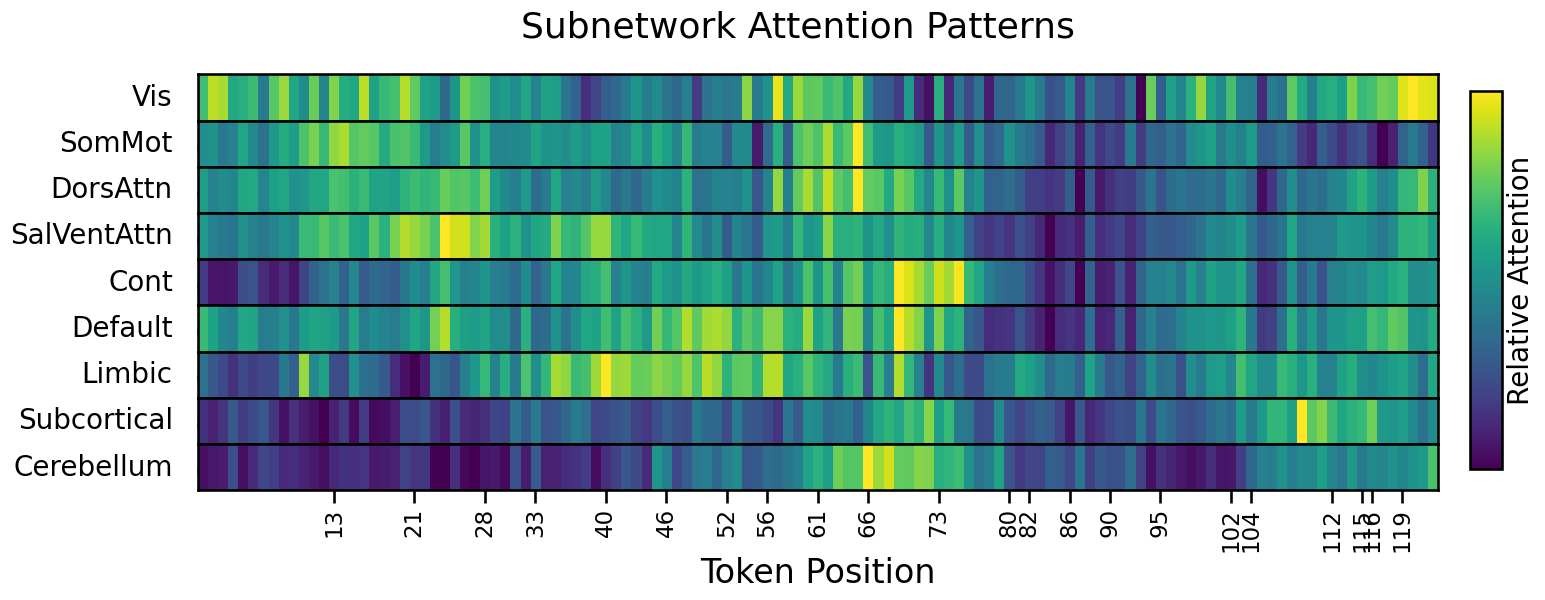

In [44]:
# Global font size parameter
FONTSIZE = 24

def plot_network_attention_rows(network_attns, chrom_switches, chrom_ticks=False, smooth=False):
    '''
    Plot attention weights for all networks as rows in separate subplots
    '''
    if not network_attns:  # Check if dictionary is empty
        print("No attention weights to plot")
        return None
        
    # Get number of networks and tokens
    n_networks = len(network_info)  # Use network_info length instead
    n_tokens = len(next(iter(network_attns.values())))
    
    # Create figure with subplots for each network
    fig, axes = plt.subplots(n_networks, 1, figsize=(16, 0.6*n_networks))
    if n_networks == 1:  # Convert single axis to array for consistent indexing
        axes = [axes]
    fig.suptitle("Subnetwork Attention Patterns", fontsize=FONTSIZE+2, y=1.0)
    
    # Initialize matrix to store all attention values for normalization
    all_attention = np.zeros((n_networks, n_tokens))
    
    # First pass to get global min/max for normalization
    for i, (network_name, _) in enumerate(network_info.items()):
        row_data = network_attns[network_name]
        if smooth:
            from scipy.ndimage import gaussian_filter1d
            row_data = gaussian_filter1d(row_data, sigma=.5)
        all_attention[i] = row_data
    
    # Process each network's attention into a separate subplot
    # Use network_info to maintain order
    for i, (network_name, _) in enumerate(network_info.items()):
        row_data = all_attention[i]
            
        # Plot heatmap for this network with local min/max scaling
        vmin, vmax = row_data.min(), row_data.max()
        im = axes[i].imshow(row_data.reshape(1,-1), cmap="viridis", 
                          aspect='auto', vmin=vmin, vmax=vmax)
        
        # Set labels and ticks with closer positioning
        axes[i].set_ylabel(network_name, fontsize=FONTSIZE-4, rotation=0, ha='right', va='center', labelpad=-150)
        
        # Only show x-axis labels on bottom subplot
        if i == n_networks-1:
            if chrom_ticks == False:
                axes[i].set_xlabel("Token Position", fontsize=FONTSIZE)
                axes[i].set_xticks(chrom_switches)
                axes[i].tick_params(axis='x', rotation=90)
            elif chrom_ticks:
                # Use chromosome numbers instead of token positions
                chrom_labels = [str(i) for i in range(1,24)]  # Only 22 chromosomes to match ticks
                axes[i].set_xlabel("Chromosome", fontsize=FONTSIZE)
                # Shift tick positions to start at 0
                tick_positions = [0] + list(chrom_switches)  # Convert numpy array slice to list
                axes[i].set_xticks(tick_positions)
                axes[i].set_xticklabels(chrom_labels)
                axes[i].tick_params(axis='x', labelsize=FONTSIZE-10, rotation=90)
        
        # Remove y-ticks since we have network names as labels
        axes[i].set_yticks([])
        
        # Move network labels closer to plots
        axes[i].yaxis.set_label_coords(-0.02, 0.5)

    # Add single colorbar for entire figure without ticks
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Relative Attention', fontsize=FONTSIZE-4)
    cbar.set_ticks([])

    plt.subplots_adjust(right=0.9, hspace=0.0)
    plt.show()

    return all_attention

all_attention = plot_network_attention_rows(network_attns, chrom_switches_60, chrom_ticks=False)


In [45]:
# Get attention weights for CLS model
predictions_ukbb_cls, targets_ukbb_cls, avg_cls_attn = smt_cls_UKBB_model.predict(dataloader_UKBB, collect_attn=True, save_attn_path=None) #'attn_SMT_cls_ukbb_seed42_0.npy')
print("Predictions shape:", predictions_ukbb_cls.shape)
print("Targets shape:", targets_ukbb_cls.shape)
print("Average CLS attention shape:", avg_cls_attn.shape)


Predictions shape: (206570,)
Targets shape: (206570,)
Average CLS attention shape: (124,)


[0.01671092 0.0135351  0.01342278 0.01342958 0.01338526 0.01332441
 0.01339776 0.01345731 0.01370126 0.01381036 0.01393974 0.01399695
 0.01407366 0.01420859 0.01411781 0.01406608 0.01408707 0.01382347
 0.01318128 0.01311096 0.01293816 0.01261714 0.01213875 0.01095783
 0.01099504 0.01078025 0.01045211 0.00956723 0.00966785 0.0097624
 0.00961123 0.0089317  0.00865796 0.00879602 0.00832198 0.00817428
 0.00780998 0.00811939 0.00775134 0.00788659 0.00721469 0.00716588
 0.00708348 0.00697313 0.0069085  0.00688391 0.00677237 0.0069333
 0.00660025 0.00657857 0.00649437 0.00648793 0.00631597 0.0062279
 0.00620673 0.00621628 0.00607464 0.00601702 0.00598781 0.00611482
 0.00607807 0.00593595 0.00587946 0.00584819 0.00588533 0.00590531
 0.00593    0.00585604 0.00592506 0.00593119 0.00571462 0.00571921
 0.00585957 0.00572561 0.00578076 0.00589026 0.00579806 0.00578253
 0.00579896 0.00588082 0.00583202 0.00575903 0.00582314 0.00580745
 0.00576038 0.0058331  0.00588852 0.00568606 0.00579429 0.0058004

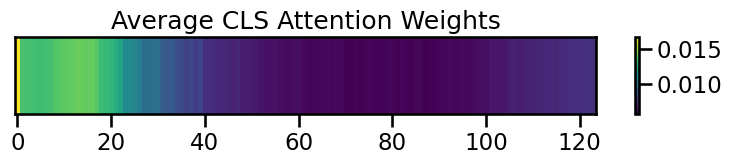

In [46]:
# Load and display attention weights
# attn_weights = np.load('notebooks/NeurIPS/attn_heads/attn_base_SMT_cls_ukbb_seed42_fold0.npy')
attn_weights = avg_cls_attn
print(attn_weights)
plt.figure(figsize=(10,1))
plt.imshow(attn_weights.reshape(1,-1), cmap='viridis', aspect='auto')
plt.colorbar(fraction=0.2)
plt.yticks([])
plt.title('Average CLS Attention Weights')
plt.show()

In [47]:
# reorder network info to match desired plotting order
network_info = {
    'Vis': ('Vis', 3660),
    'SomMot': ('SomMot', 5852), 
    'DorsAttn': ('DorsAttn', 2070),
    'SalVentAttn': ('SalVentAttn', 2162),
    'Cont': ('Cont', 2652),
    'Default': ('Default', 8190),
    'Limbic': ('Limbic', 650),
    'Subcortical': ('Subcortical', 2070),
    'Cerebellum': ('Cerebellum', 72)
}

# Collect attention for each subnetwork
network_attns = {}
for network, dataloader in network_dataloaders.items():
    # Get predictions and attention weights for this network
    _, _, network_attn = smt_cls_UKBB_model.predict(dataloader, collect_attn=True)
    network_attns[network] = network_attn.squeeze()  # Remove extra dimensions


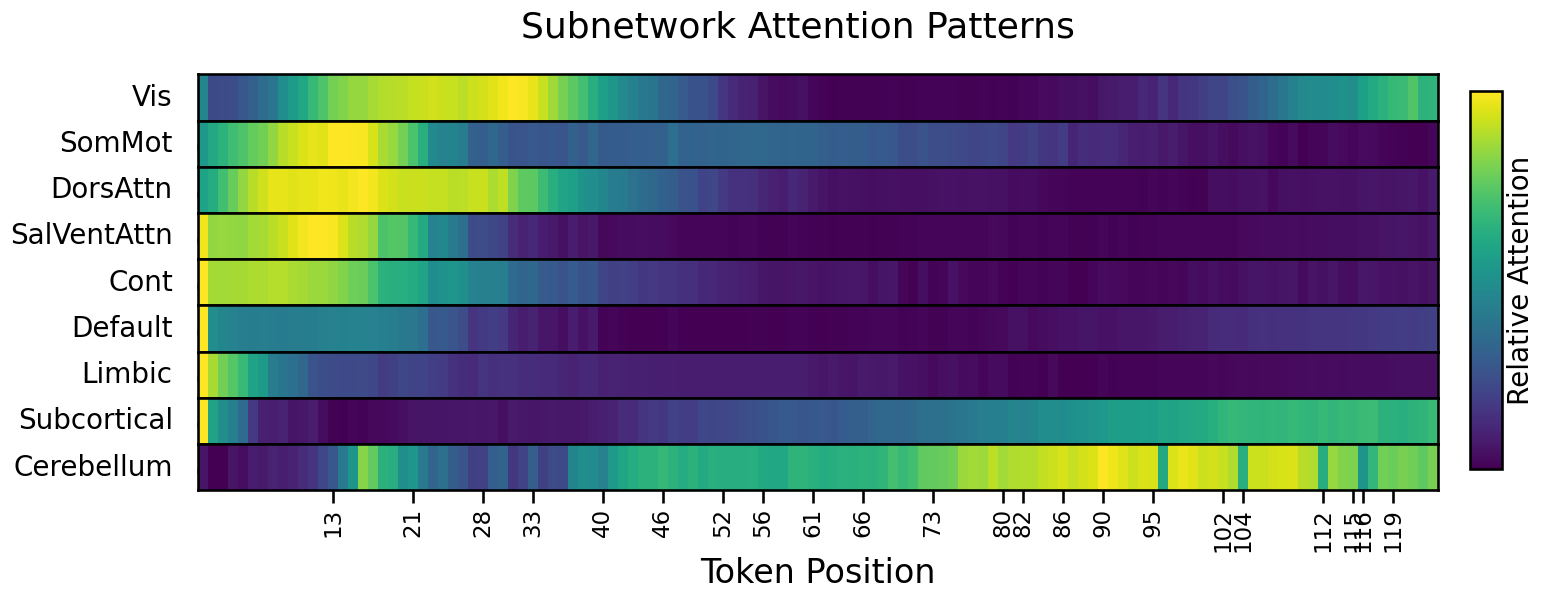

In [48]:
# Global font size parameter
FONTSIZE = 24

def plot_network_attention_rows(network_attns, chrom_switches, chrom_ticks=False, smooth=False, has_cls=False):
    '''
    Plot attention weights for all networks as rows in separate subplots
    '''
    if not network_attns:  # Check if dictionary is empty
        print("No attention weights to plot")
        return None
        
    # Get number of networks and tokens
    n_networks = len(network_info)  # Use network_info length instead
    n_tokens = len(next(iter(network_attns.values())))
    
    # Create figure with subplots for each network
    fig, axes = plt.subplots(n_networks, 1, figsize=(16, 0.6*n_networks))
    if n_networks == 1:  # Convert single axis to array for consistent indexing
        axes = [axes]
    fig.suptitle("Subnetwork Attention Patterns", fontsize=FONTSIZE+2, y=1.0)
    
    # Initialize matrix to store all attention values for normalization
    all_attention = np.zeros((n_networks, n_tokens))
    
    # First pass to get global min/max for normalization
    for i, (network_name, _) in enumerate(network_info.items()):
        row_data = network_attns[network_name]
        if smooth:
            from scipy.ndimage import gaussian_filter1d
            row_data = gaussian_filter1d(row_data, sigma=.5)
        all_attention[i] = row_data
    
    # Process each network's attention into a separate subplot
    # Use network_info to maintain order
    for i, (network_name, _) in enumerate(network_info.items()):
        row_data = all_attention[i]
            
        # Plot heatmap for this network with local min/max scaling
        vmin, vmax = row_data.min(), row_data.max()
        im = axes[i].imshow(row_data.reshape(1,-1), cmap="viridis", 
                          aspect='auto', vmin=vmin, vmax=vmax)
        
        # Set labels and ticks with closer positioning
        axes[i].set_ylabel(network_name, fontsize=FONTSIZE-4, rotation=0, ha='right', va='center', labelpad=-150)
        
        # Only show x-axis labels on bottom subplot
        if i == n_networks-1:
            if chrom_ticks == False:
                axes[i].set_xlabel("Token Position", fontsize=FONTSIZE)
                # Adjust ticks for CLS token if present
                if has_cls:
                    ticks = [0] + [x+1 for x in chrom_switches]  # Shift ticks right by 1
                    axes[i].set_xticks(ticks)
                else:
                    axes[i].set_xticks(chrom_switches)
                axes[i].tick_params(axis='x', rotation=90)
            elif chrom_ticks:
                # Use chromosome numbers instead of token positions
                chrom_labels = ['CLS'] + [str(i) for i in range(1,24)] if has_cls else [str(i) for i in range(1,24)]
                axes[i].set_xlabel("Chromosome", fontsize=FONTSIZE)
                # Shift tick positions to start at 0
                if has_cls:
                    tick_positions = [0] + [x+1 for x in [0] + list(chrom_switches)]  # Add CLS position and shift others
                else:
                    tick_positions = [0] + list(chrom_switches)
                axes[i].set_xticks(tick_positions)
                axes[i].set_xticklabels(chrom_labels)
                axes[i].tick_params(axis='x', labelsize=FONTSIZE-10, rotation=90)
        
        # Remove y-ticks since we have network names as labels
        axes[i].set_yticks([])
        
        # Move network labels closer to plots
        axes[i].yaxis.set_label_coords(-0.02, 0.5)

    # Add single colorbar for entire figure without ticks
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Relative Attention', fontsize=FONTSIZE-4)
    cbar.set_ticks([])

    plt.subplots_adjust(right=0.9, hspace=0.0)
    plt.show()

    return all_attention

all_attention = plot_network_attention_rows(network_attns, chrom_switches_60, chrom_ticks=False)


Head plotting helpers

In [51]:
# Global font size parameter
FONTSIZE = 24

def plot_all_attention_heads(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]

    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        if head == 0:  # Only add labels for first plot
            axes[head].set_xlabel("Key", fontsize=FONTSIZE)
            axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add chromosome switch points as ticks
        axes[head].set_xticks(chrom_switches)
        axes[head].set_yticks(chrom_switches)
        axes[head].tick_params(axis='both', which='major', labelsize=FONTSIZE-10)
        axes[head].tick_params(axis='x', rotation=90)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xticks(chrom_switches)
    axes[-1].set_yticks(chrom_switches)
    axes[-1].tick_params(axis='both', which='major', labelsize=FONTSIZE-8)
    axes[-1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()

    # Plot colorbar separately
    # fig_cbar = plt.figure(figsize=(2, 6))
    # cbar = plt.colorbar(im, cax=plt.gca(), label=f"[{vmin:.2f}, {vmax:.2f}]")
    # cbar.ax.tick_params(labelsize=FONTSIZE-4)
    # cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    # plt.show()

def plot_average_head(avg_attn, chrom_switches):
    '''
    Plot average attention weights across all heads
    '''
    # Average across all heads
    avg_head = avg_attn.mean(axis=0)
    
    plt.figure(figsize=(8, 7))
    vmin, vmax = avg_head.min(), avg_head.max()
    im = plt.imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    plt.title("Average Attention Across All Heads", fontsize=FONTSIZE+2)
    plt.xlabel("Key", fontsize=FONTSIZE)
    plt.ylabel("Query", fontsize=FONTSIZE)
    plt.xticks(chrom_switches, fontsize=FONTSIZE-6, rotation=90)
    plt.yticks(chrom_switches, fontsize=FONTSIZE-6)
    plt.show()

def plot_all_attention_heads_true_ticks(attn_weights, chrom_switches):
    '''
    Plot individual attention weights for each head plus average in a single row
    '''
    num_heads = attn_weights.shape[0]
    max_idx = attn_weights.shape[1]
    tick_indices = list(range(0, max_idx, 5))

    # Create a figure with num_heads + 1 subplots in a single row (extra one for average)
    fig, axes = plt.subplots(1, num_heads + 1, figsize=(25, 6))
    
    # Plot individual heads
    for head in range(num_heads):
        vmin, vmax = attn_weights[head].min(), attn_weights[head].max()
        im = axes[head].imshow(attn_weights[head], cmap="viridis", vmin=vmin, vmax=vmax)
        axes[head].set_title(f"Head {head+1}", fontsize=FONTSIZE+2)
        axes[head].set_xlabel("Key", fontsize=FONTSIZE)
        axes[head].set_ylabel("Query", fontsize=FONTSIZE)
        # Add indices as ticks with smaller font
        axes[head].set_xticks(tick_indices)
        axes[head].set_yticks(tick_indices)
        axes[head].tick_params(axis='both', which='major', labelsize=6)
        cbar = fig.colorbar(im, ax=axes[head], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
        cbar.ax.tick_params(labelsize=FONTSIZE-8)
        cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    # Plot average head
    avg_head = attn_weights.mean(axis=0)
    vmin, vmax = avg_head.min(), avg_head.max()
    im = axes[-1].imshow(avg_head, cmap="viridis", vmin=vmin, vmax=vmax)
    axes[-1].set_title("Average", fontsize=FONTSIZE+2)
    axes[-1].set_xlabel("Key", fontsize=FONTSIZE)
    axes[-1].set_ylabel("Query", fontsize=FONTSIZE)
    axes[-1].set_xticks(tick_indices)
    axes[-1].set_yticks(tick_indices)
    axes[-1].tick_params(axis='both', which='major', labelsize=6)
    cbar = fig.colorbar(im, ax=axes[-1], label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.3)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    
    plt.tight_layout()
    plt.show()


Compute attention weights

In [52]:
# UKBB - continue from here
# Get predictions and attention weights for base model with pooling
predictions_ukbb_base = smt_UKBB_model.predict(dataloader_UKBB, collect_attn=True, save_attn_path=None) #'attn_SMT_pooling_ukbb_seed42_0.npy')
predictions_ukbb_base, targets_ukbb_base, avg_pooled_attn = predictions_ukbb_base

In [53]:
predictions_ukbb_base.shape

(206570,)

In [54]:
targets_ukbb_base.shape

(206570,)

In [55]:
avg_pooled_attn.shape

(123,)

[0.00718757 0.00663664 0.00832027 0.00624117 0.00912272 0.0090938
 0.00710894 0.00768213 0.00844363 0.00889233 0.01137779 0.01189192
 0.00924368 0.00997756 0.00927031 0.01122583 0.00960719 0.00800227
 0.00742664 0.00880496 0.0077364  0.00723643 0.0079179  0.0080813
 0.00929127 0.00938726 0.01007527 0.0092687  0.01045088 0.00813013
 0.00965444 0.00849908 0.01028911 0.00849642 0.00707284 0.00904579
 0.00987135 0.00970495 0.01081597 0.008854   0.01171447 0.01139395
 0.01205381 0.01080228 0.00997114 0.01064636 0.01271162 0.0086805
 0.01045763 0.01103183 0.01038907 0.01088625 0.01164693 0.00923602
 0.01015622 0.00846455 0.00745454 0.0095877  0.00793855 0.00819445
 0.00859578 0.00844354 0.00671229 0.00618541 0.00678788 0.00990885
 0.00827105 0.00926789 0.00695971 0.00618977 0.00888055 0.00660334
 0.00696079 0.00858061 0.00651089 0.00801227 0.00646967 0.00565356
 0.00606497 0.00712013 0.00600633 0.00574534 0.00781638 0.00723423
 0.00537765 0.00634456 0.00510206 0.00593839 0.00617592 0.0050321

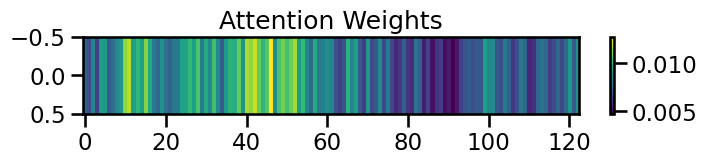

In [56]:
# Load and display attention weights
#attn_weights = np.load('notebooks/NeurIPS/attn_heads/attn_base_SMT_pooling_ukbb_seed42_fold0.npy')
attn_weights = avg_pooled_attn
print(attn_weights)
plt.figure(figsize=(8,1))
plt.imshow(attn_weights.reshape(1,-1), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Attention Weights')
plt.show()

In [57]:
# Get predictions and attention weights for CLS model with pooling  
predictions_ukbb_cls = smt_cls_UKBB_model.predict(dataloader_UKBB, collect_attn=True, save_attn_path='attn_cls_SMT_pooling_ukbb_seed42_fold0.npy')
predictions_ukbb_cls, targets_ukbb_cls = predictions_ukbb_cls

TorchRuntimeError: Failed running call_module L__self___input_projection(*(FakeTensor(..., device='cuda:0', size=(1024, 369, 20)),), **{}):
Unhandled FakeTensor Device Propagation for aten.mm.default, found two different devices cuda:0, cpu

from user code:
   File "/scratch/asr655/neuroinformatics/GeneEx2Conn/models/transformer_models.py", line 433, in forward
    x = self.input_projection(x)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [ ]:
# Load and display attention weights
attn_weights = np.load('notebooks/NeurIPS/attn_heads/attn_cls_SMT_pooling_ukbb_seed42_fold0.npy')
print(attn_weights)
plt.figure(figsize=(8,1))
plt.imshow(attn_weights.reshape(1,-1), cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Attention Weights')
plt.show()

In [42]:
saved = False

if saved != True: 
    for i in range(9):
        network_name, num_pairs = network_info[i]
        print(f'Processing {network_name} network ({num_pairs} region pairs)')
        
        predictions_base_sub, targets_base_sub = smt_UKBB_model.predict(
            network_dataloaders[network_name],
            collect_attn=True,
            save_attn_path=f'attn_base_SMT_pooling_ukbb_{network_name}.npy'
        )
        
        predictions_cls_sub, targets_cls_sub = smt_cls_UKBB_model.predict(
            network_dataloaders[network_name],
            collect_attn=True, 
            save_attn_path=f'attn_cls_SMT_pooling_ukbb_{network_name}.npy'
        )

Processing Cerebellum network (72 region pairs)
Processing Cont network (2652 region pairs)
Processing Default network (8190 region pairs)
Processing DorsAttn network (2070 region pairs)
Processing Limbic network (650 region pairs)
Processing SalVentAttn network (2162 region pairs)
Processing SomMot network (5852 region pairs)
Processing Subcortical network (2070 region pairs)
Processing Vis network (3660 region pairs)


In [ ]:
# reorder network info 
network_info = {
    0: ('Vis', 3660),
    1: ('SomMot', 5852), 
    2: ('DorsAttn', 2070),
    3: ('SalVentAttn', 2162),
    4: ('Cont', 2652),
    5: ('Default', 8190),
    6: ('Limbic', 650),
    7: ('Subcortical', 2070),
    8: ('Cerebellum', 72)
}


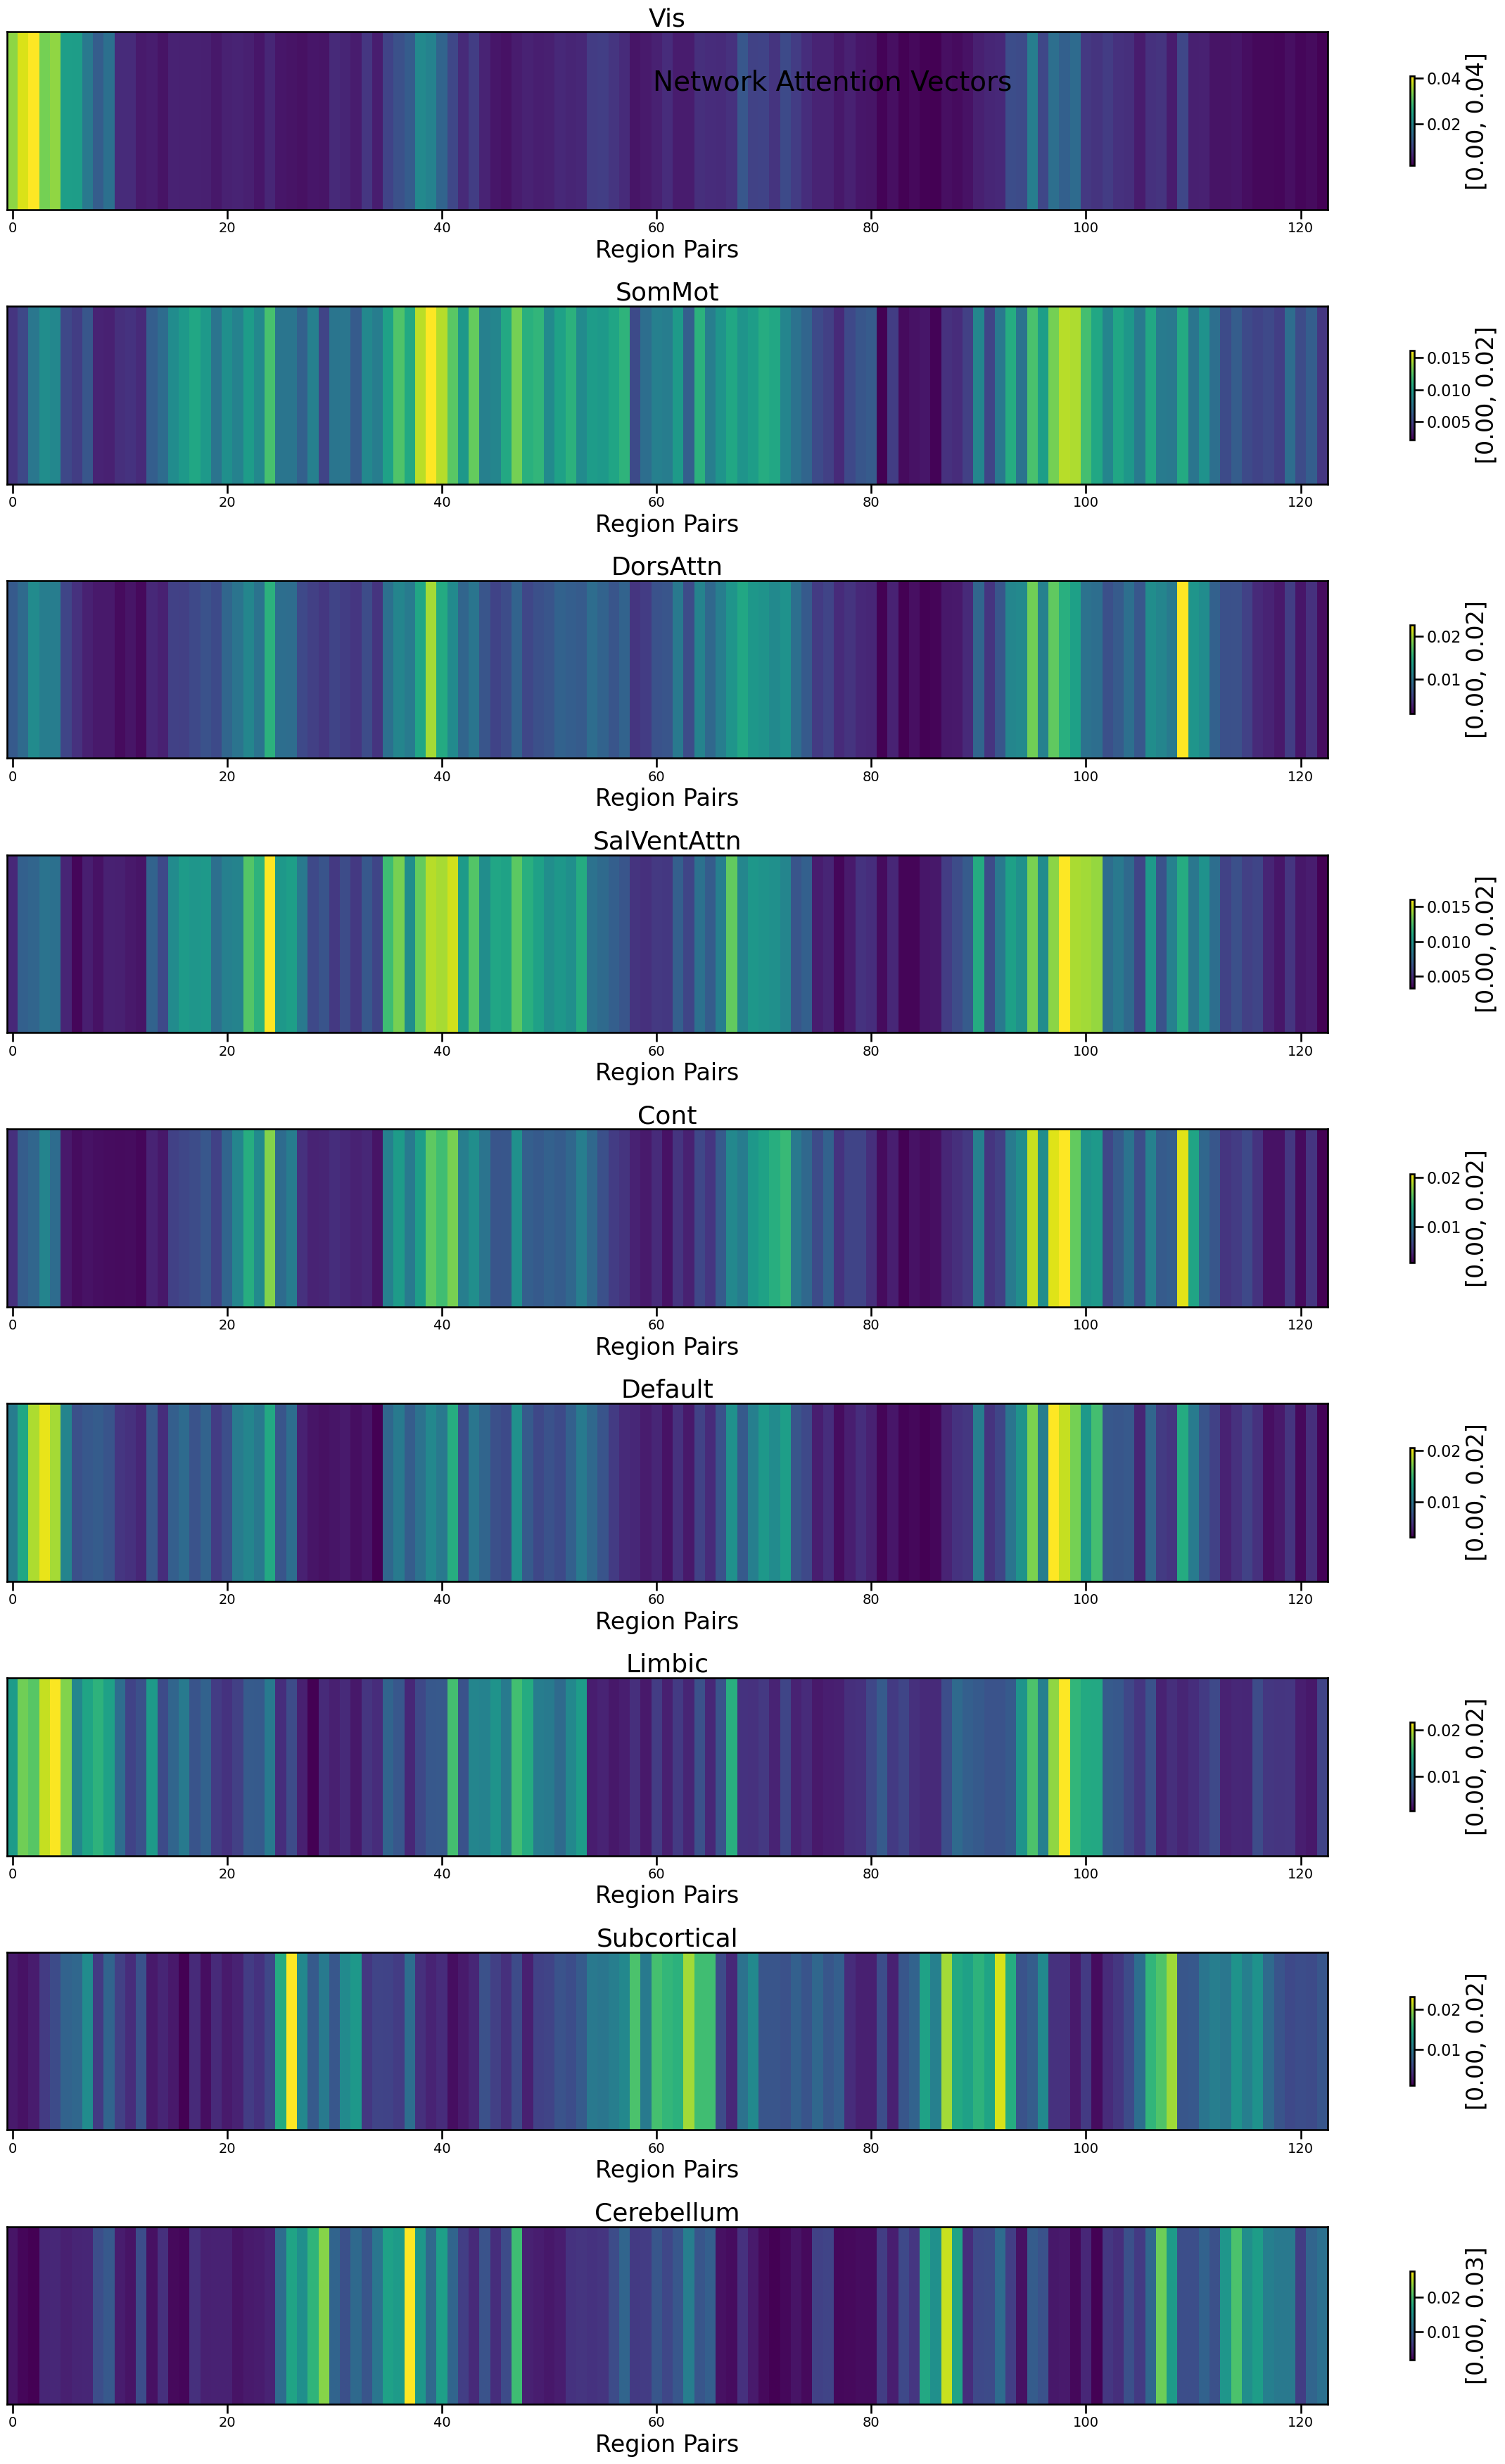

In [47]:
# Load attention weights for each network
network_attns = {}
for network, num_nodes in network_info.items():
    network_name = network_info[network][0]
    attn_path = f'notebooks/NeurIPS/attn_heads/attn_base_SMT_pooling_ukbb_{network_name}.npy'
    network_attns[network_name] = np.load(attn_path)

# Global font size parameter
FONTSIZE = 24

def plot_network_head(attn_weights, network_name, ax):
    '''
    Plot attention vector for a specific network
    '''
    # Reshape attention weights into 1D vector
    attn_vec = attn_weights.reshape(1,-1)
    
    vmin, vmax = attn_vec.min(), attn_vec.max()
    im = ax.imshow(attn_vec, cmap="viridis", aspect='auto', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.5)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    ax.set_title(f"{network_name}", fontsize=FONTSIZE+2)
    ax.set_xlabel("Region Pairs", fontsize=FONTSIZE)
    ax.tick_params(axis='both', labelsize=FONTSIZE-10)
    ax.set_yticks([])

# Create subplot grid with 9 rows and 1 column
fig = plt.figure(figsize=(24, 36))
fig.suptitle("Network Attention Vectors", fontsize=FONTSIZE+4, y=0.95)

# Plot attention weights for each network
for i, (network_name, attn) in enumerate(network_attns.items()):
    ax = plt.subplot(9, 1, i+1)
    plot_network_head(attn, network_name, ax)

plt.tight_layout()
plt.show()


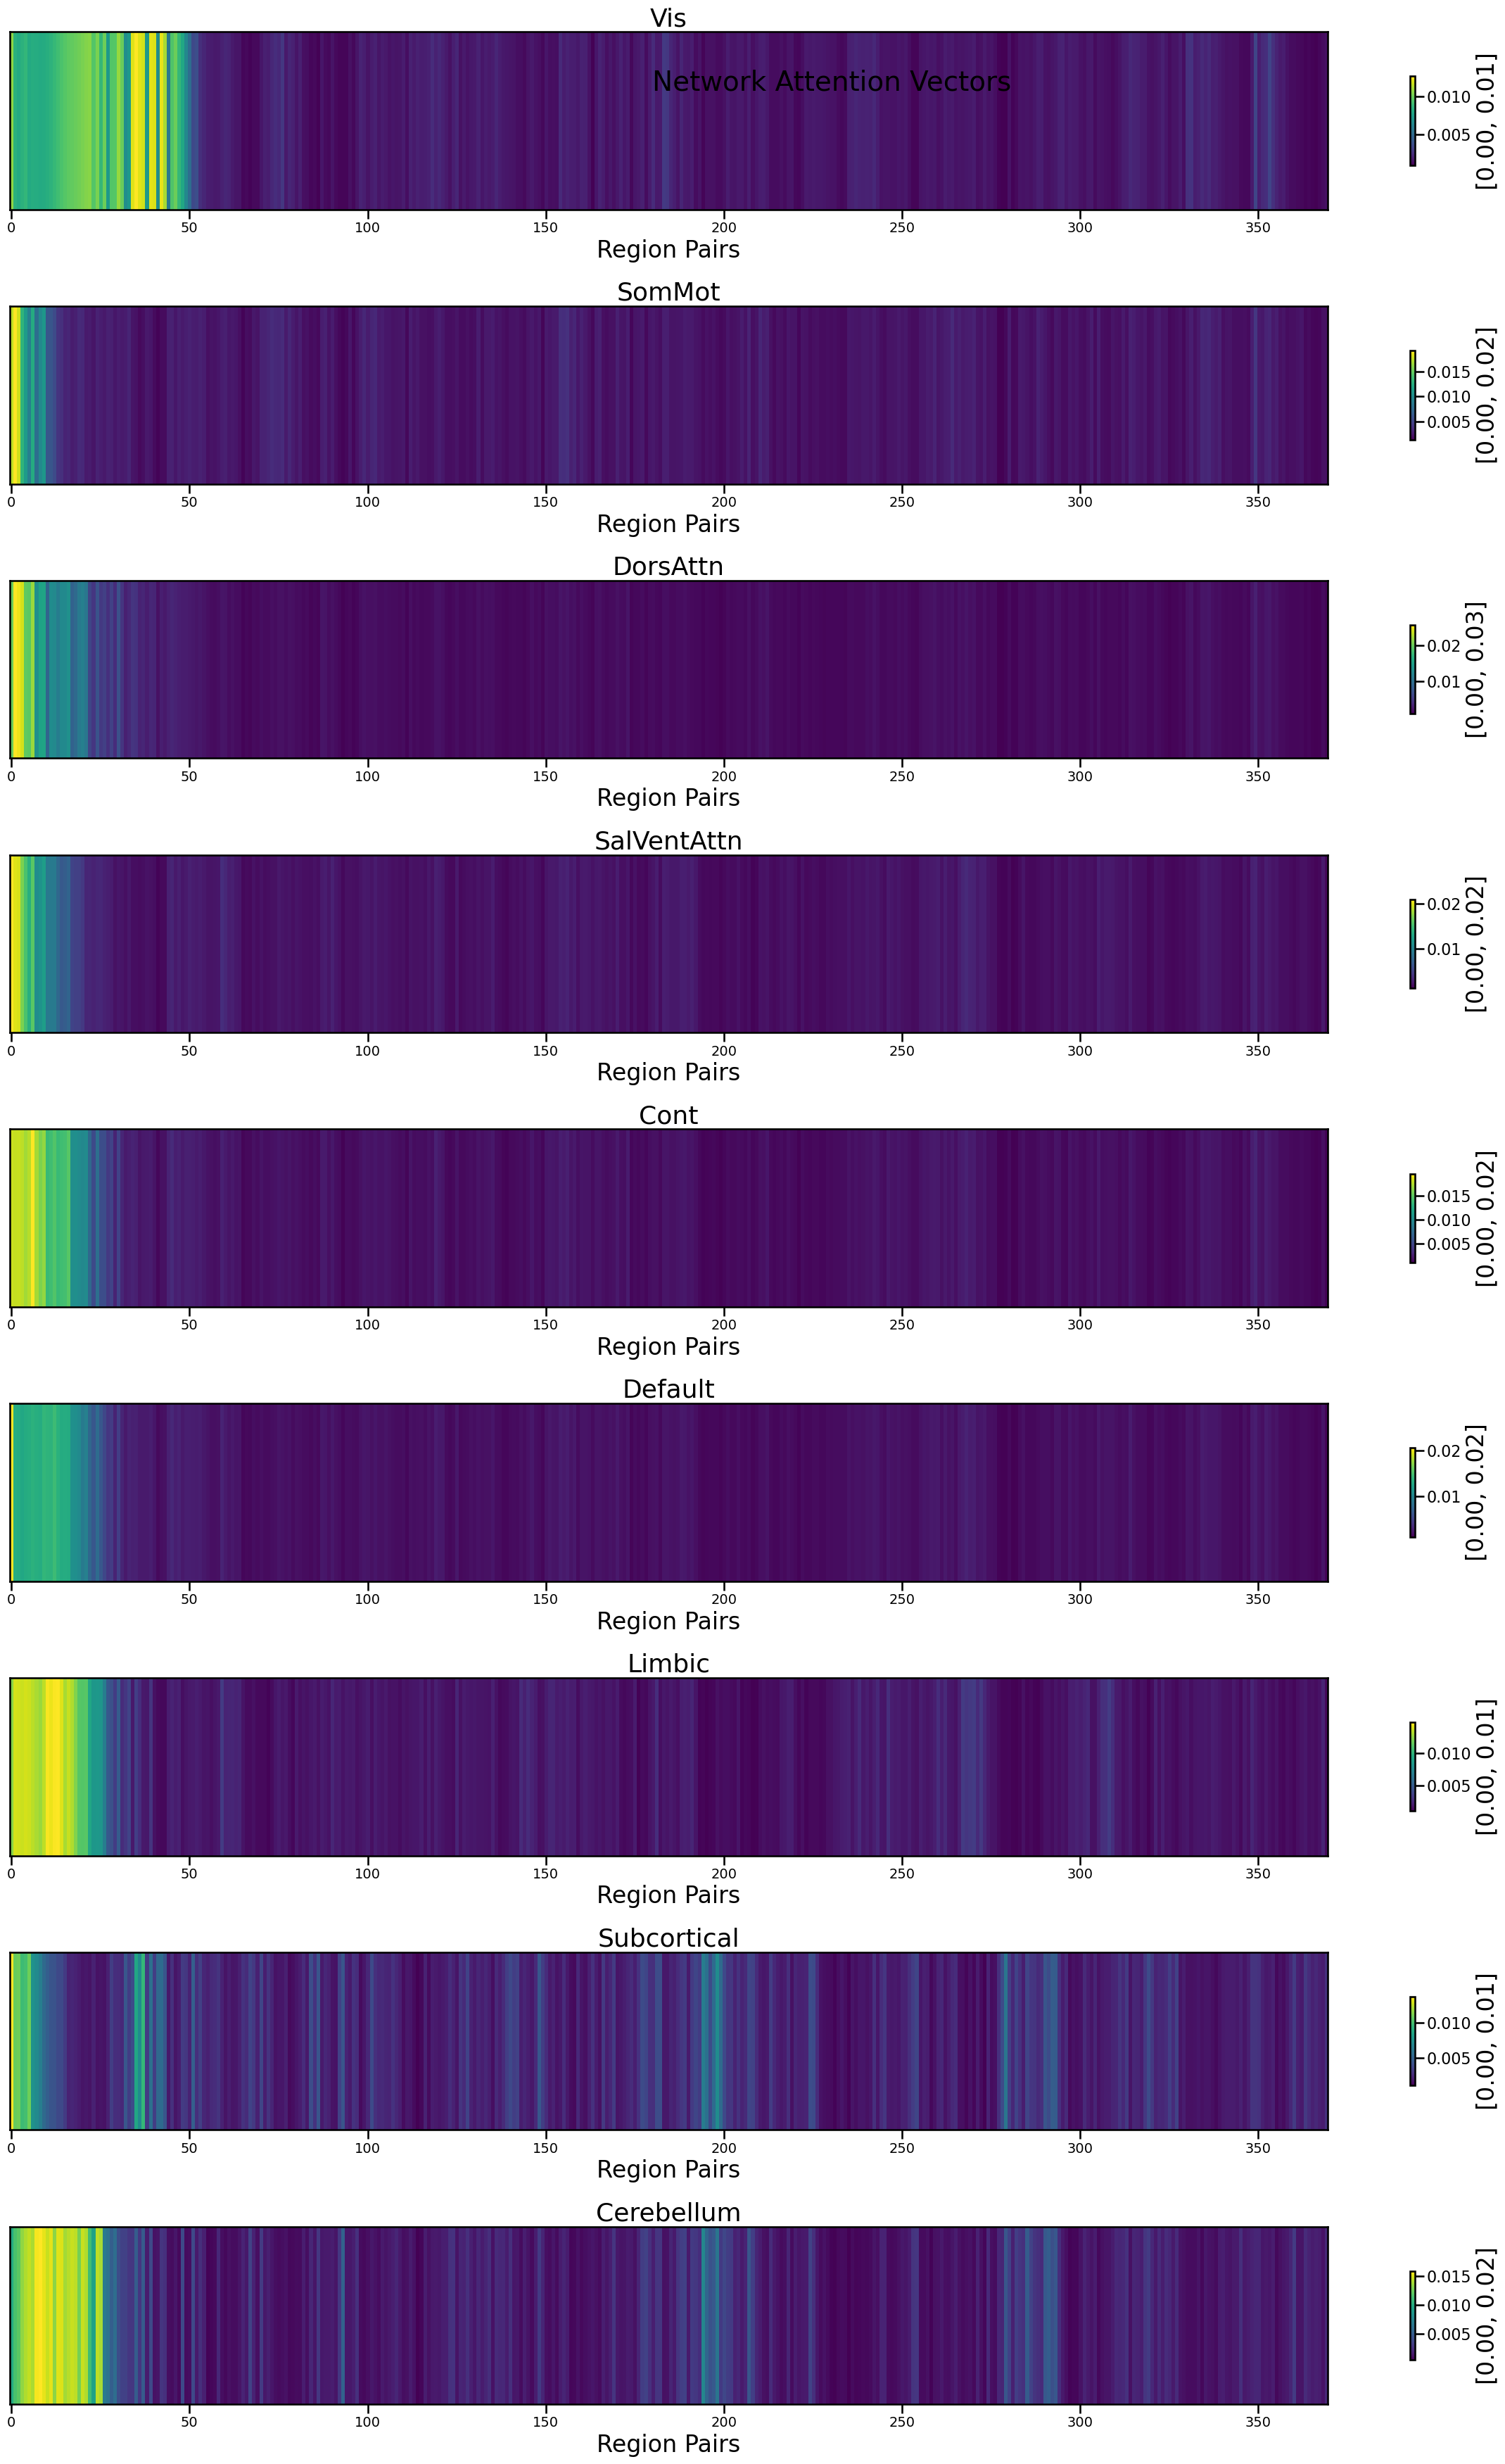

In [48]:
# Load attention weights for each network
network_attns = {}
for network, num_nodes in network_info.items():
    network_name = network_info[network][0]
    attn_path = f'notebooks/NeurIPS/attn_heads/attn_cls_SMT_pooling_ukbb_{network_name}.npy'
    network_attns[network_name] = np.load(attn_path)

# Global font size parameter
FONTSIZE = 24

def plot_network_head(attn_weights, network_name, ax):
    '''
    Plot attention vector for a specific network
    '''
    # Reshape attention weights into 1D vector
    attn_vec = attn_weights.reshape(1,-1)
    
    vmin, vmax = attn_vec.min(), attn_vec.max()
    im = ax.imshow(attn_vec, cmap="viridis", aspect='auto', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax, label=f"[{vmin:.2f}, {vmax:.2f}]", shrink=0.5)
    cbar.ax.tick_params(labelsize=FONTSIZE-8)
    cbar.set_label(f"[{vmin:.2f}, {vmax:.2f}]", fontsize=FONTSIZE)
    ax.set_title(f"{network_name}", fontsize=FONTSIZE+2)
    ax.set_xlabel("Region Pairs", fontsize=FONTSIZE)
    ax.tick_params(axis='both', labelsize=FONTSIZE-10)
    ax.set_yticks([])

# Create subplot grid with 9 rows and 1 column
fig = plt.figure(figsize=(24, 36))
fig.suptitle("Network Attention Vectors", fontsize=FONTSIZE+4, y=0.95)

# Plot attention weights for each network
for i, (network_name, attn) in enumerate(network_attns.items()):
    ax = plt.subplot(9, 1, i+1)
    plot_network_head(attn, network_name, ax)

plt.tight_layout()
plt.show()
